Import all the Dependecies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error , r2_score
import xgboost as xgb 
import joblib
import warnings


Step 1: Importing and Understanding the Dataset

In [4]:
#Import Train Data
df = pd.read_csv('../Dashboard/dataset.csv')


In [5]:
# --- Step 1: Understanding the Dataset ---
print("Training Dataset Shape:", df.shape)
display(df.head())

Training Dataset Shape: (2919, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [7]:
# Check for missing values in both datasets
def missing_values_table(df):
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
    missing_percentage = (missing_values / len(df)) * 100
    return pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

display(missing_values_table(df))


,Missing Values,Percentage
PoolQC,2909,99.657417
MiscFeature,2814,96.402878
Alley,2721,93.216855
Fence,2348,80.438506
MasVnrType,1766,60.500171
FireplaceQu,1420,48.646797
LotFrontage,486,16.649538
GarageQual,159,5.447071
GarageYrBlt,159,5.447071
GarageCond,159,5.447071


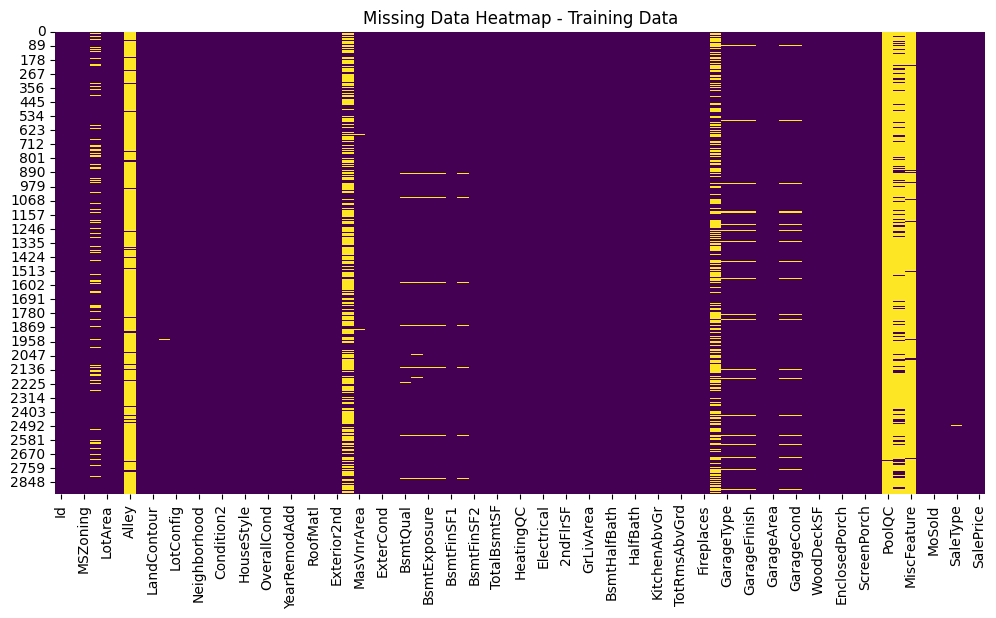

In [8]:
# Visualize missing data patterns
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Heatmap - Training Data")
plt.show()

Step 2 : Data Preprocessing

In [9]:
# Drop columns with too many missing values
drop_columns = ['PoolQC', 'MiscFeature', 'Alley', 'Fence']
df.drop(columns=drop_columns, inplace=True)

In [10]:
# Separate numerical and categorical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('SalePrice')  # Exclude target variable
cat_cols = df.select_dtypes(include=['object']).columns

In [12]:
# Impute missing values
imputer_num = SimpleImputer(strategy='median')
df[num_cols] = imputer_num.fit_transform(df[num_cols])

imputer_cat = SimpleImputer(strategy='most_frequent')
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

In [11]:
# Encode categorical variables
encoder = LabelEncoder()
for col in cat_cols:
    df[col] = encoder.fit_transform(df[col])
    df_test[col] = encoder.transform(df_test[col])


In [13]:
# Feature engineering: Create 'TotalSF'
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

df.drop(columns=['Id'], inplace=True)

In [14]:
# Data Validation (Check for NaN after imputation)
print("NaN values after imputation (Training):", df.isnull().sum().sum())

NaN values after imputation (Training): 0


In [15]:
df.to_csv('cleaneddata.csv', index=False)
print("Cleaned file saved as cleaneddata.csv")

Cleaned file saved as cleaneddata.csv
